<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Введение" data-toc-modified-id="Введение-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Введение</a></span></li><li><span><a href="#Загрузка-и-подготовка-данных" data-toc-modified-id="Загрузка-и-подготовка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Загрузка и подготовка данных</a></span></li><li><span><a href="#Обучение-и-проверка-модели" data-toc-modified-id="Обучение-и-проверка-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение и проверка модели</a></span></li><li><span><a href="#Подготовка-к-расчёту-прибыли" data-toc-modified-id="Подготовка-к-расчёту-прибыли-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Подготовка к расчёту прибыли</a></span></li><li><span><a href="#Расчёт-прибыли-и-рисков" data-toc-modified-id="Расчёт-прибыли-и-рисков-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Расчёт прибыли и рисков</a></span></li><li><span><a href="#Заключение" data-toc-modified-id="Заключение-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Заключение</a></span></li></div>

## Введение

Цель: построить модель для определения региона, где добыча принесёт наибольшую прибыль.

Исходные данные:
- пробы нефти и производительность скважин в трех регионах
- число скважин для исследования - 500
- число скважин для разработки, которые отобраны с помощью машинного обучения - 200
- бюджет на разработку скважин в регионе — 10 млрд рублей.
- 1 баррель сырья стоит 450 рублей
- вероятность убытков должна быть менее 2.5%

Порядок работы:
- загрузить три датасета, каждый из которых иллюстрируют отдельный регион, подготовить данные
- разбить данные на обучающую и валидационную выборки в соотношении 75:25.
- обучить и проверить модель для каждого региона, определить RMSE
- рассчитать достаточный объём сырья для безубыточной разработки новой скважины, cравнить полученный объём сырья со средним запасом в каждом регионе.
- написать функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели
- рассчитать прибыль для скважин, в которых объем сырья соотаветствует максимальному значению предсказаний
- посчитать риски и прибыль для каждого региона, применяя технику Bootstrap на 1000 выборок
- определить 95-% доверительный интервал и риск убытков
- написать выводы

## Загрузка и подготовка данных

Загружаем необходимые библиотеки:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from math import ceil 

Обозначим независимые переменные:

In [2]:
DEVELOP_POINTS = 500 #количество точек для исследования
EXPLOITATION_POINTS = 200 #количество точек для разработки и подсчета прибыли
REGION_BUDGET = 10*10**9 #бюджет региона
WELL_INCOME = 450 #руб за 1 барр

Выполняем чтение датасетов:

In [3]:
data_0 = pd.read_csv('/datasets/geo_data_0.csv')
data_1 = pd.read_csv('/datasets/geo_data_1.csv')
data_2 = pd.read_csv('/datasets/geo_data_2.csv')

Первое знакомство с данными: 10000 строк, 5 колонок, в строке id - строковый формат, в остальных - с плавающей точкой.

In [4]:
data_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [5]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [6]:
data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Выведем первые 5 строк в каждом датафрейме, чтобы убедиться, что данные загрузились корректно.

In [7]:
data_0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [8]:
data_1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [9]:
data_2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


Выполним проверку на дубликаты и пропуски.

In [10]:
data_0 = data_0.drop_duplicates()
data_0.shape

(100000, 5)

In [11]:
data_1 = data_1.drop_duplicates()
data_1.shape

(100000, 5)

In [12]:
data_2 = data_2.drop_duplicates()
data_2.shape

(100000, 5)

In [13]:
data_0.isna().sum()

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

In [14]:
data_1.isna().sum()

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

In [15]:
data_2.isna().sum()

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

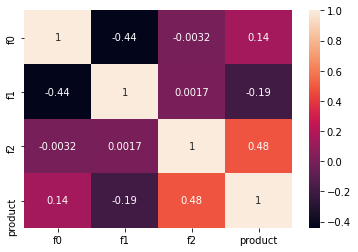

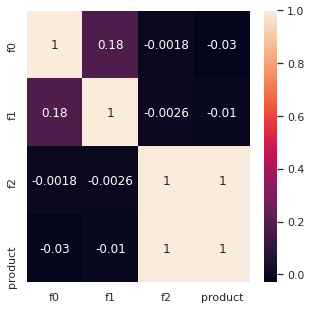

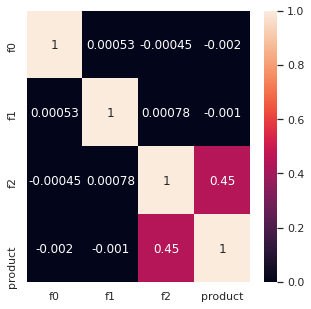

In [16]:
for data in [data_0,data_1,data_2]:
    corr = data.drop('id',axis=1).corr()
    plt.figure()
    fig = sns.heatmap(corr, annot=True);
    sns.set(rc = {'figure.figsize':(5,5)})

Вывод: в каждом датасете собраны данные с названием скважин, признаками свойств нефти (предположительно) и объемом добываемой продукции. Дубликаты и пропуски отсутствуют. Мы построили график корреляций для трех датасетов и определили, что наиболее сильная зависимость объема нефти от признака f2. Во втором датасете особенно.

## Обучение и проверка модели

Разделим данные на целевой признак и обучающие (удалим признак "id", который является уникальным и не повышает качество модели)

In [17]:
target_0 = data_0['product']
target_1 = data_1['product']
target_2 = data_2['product']

In [18]:
features_0 = data_0.loc[:,~data_0.columns.isin (['id','product'])]
features_1 = data_1.loc[:,~data_1.columns.isin (['id','product'])]
features_2 = data_2.loc[:,~data_2.columns.isin (['id','product'])]

Разделим выборки на обучающую и валидационную в соотношении 75:25

In [19]:
features_0_train,features_0_valid,target_0_train,target_0_valid = train_test_split(features_0,target_0,test_size=0.25,random_state=12345)
features_1_train,features_1_valid,target_1_train,target_1_valid = train_test_split(features_1,target_1,test_size=0.25,random_state=12345)
features_2_train,features_2_valid,target_2_train,target_2_valid = train_test_split(features_2,target_2,test_size=0.25,random_state=12345)

Обучим модели линейной регрессии на обучающиx и целевыx признаках, получим - предсказания, предсказания для валидационной выборки, средне-квадратичное отклонение и корень из него.

In [20]:
model = LinearRegression()
model.fit(features_0_train, target_0_train)
predicted_0_valid = model.predict(features_0_valid)
predicted_0 = model.predict(features_0)
mse_0 = mean_squared_error(target_0_valid, predicted_0_valid)
rmse_0 = mse_0 ** 0.5

In [21]:
model = LinearRegression()
model.fit(features_1_train, target_1_train)
predicted_1_valid = model.predict(features_1_valid)
predicted_1 = model.predict(features_1)
mse_1 = mean_squared_error(target_1_valid, predicted_1_valid)
rmse_1 = mse_1 ** 0.5

In [22]:
model = LinearRegression()
model.fit(features_2_train, target_2_train)
predicted_2_valid = model.predict(features_2_valid)
predicted_2 = model.predict(features_2)
mse_2 = mean_squared_error(target_2_valid, predicted_2_valid)
rmse_2 = mse_2 ** 0.5

Выведем на экран сравнение предсказанного объема сырья и фактического объема сырья на валидационной выборке.

In [23]:
def dataframing (pr_target,pr_predicted):
    pr_mod = pd.DataFrame({'product_target':pr_target.to_list(),'product_predicted':pr_predicted}).head()
    return print(pr_mod)

In [24]:
dataframing(target_0_valid,predicted_0_valid)
print('\n')
dataframing(target_1_valid,predicted_1_valid)
print('\n')
dataframing(target_2_valid,predicted_2_valid)

   product_target  product_predicted
0       10.038645          95.894952
1      114.551489          77.572583
2      132.603635          77.892640
3      169.072125          90.175134
4      122.325180          70.510088


   product_target  product_predicted
0       80.859783          82.663314
1       53.906522          54.431786
2       30.132364          29.748760
3       53.906522          53.552133
4        0.000000           1.243856


   product_target  product_predicted
0       61.212375          93.599633
1       41.850118          75.105159
2       57.776581          90.066809
3      100.053761         105.162375
4      109.897122         115.303310


Сравнение средних показателей предсказанного и фактического объемов сырья, а также показатель rmse для валидационных выборок в каждом из регионов. 

In [25]:
table = pd.DataFrame({
    'aver_product_fact':[target_0_valid.mean(),target_1_valid.mean(),target_2_valid.mean()],
    'aver_product_predicted':[predicted_0_valid.mean(),predicted_1_valid.mean(),predicted_2_valid.mean()],
    'rmse':[rmse_0,rmse_1,rmse_2]})
table

,aver_product_fact,aver_product_predicted,rmse
0,92.078597,92.592568,37.579422
1,68.723136,68.728547,0.893099
2,94.884233,94.965046,40.029709


Выведем на экрен Сравнение средних фактических и предсказанных объемов сырья для общих выборок в каждом из трех регионов.

In [26]:
table_1 = pd.DataFrame({
    'aver_product_fact':[target_0.mean(),target_1.mean(),target_2.mean()],
    'aver_product_predicted':[predicted_0.mean(),predicted_1.mean(),predicted_2.mean()]
    })
table_1

,aver_product_fact,aver_product_predicted
0,92.500,92.628493
1,68.825,68.826353
2,95.000,95.020203


Вывод: после обучения модели видим, что наименьшее значение ошибки для модели второго региона.

## Подготовка к расчёту прибыли

In [27]:
v = REGION_BUDGET/(WELL_INCOME*10**3*EXPLOITATION_POINTS) #рассчитываем безубыточный объем в тыс.барр.
print(f'Объем добычи с 1 скважины, который нужен для безубыточной разработка {v} тыс.барр.')

Объем добычи с 1 скважины, который нужен для безубыточной разработка 111.11111111111111 тыс.барр.


In [28]:
print(f'Средний объем добычи с 1 одной скважины в 1 регионе {target_0.mean()} тыс.барр.')

Средний объем добычи с 1 одной скважины в 1 регионе 92.50000000000001 тыс.барр.


In [29]:
print(f'Средний объем добычи с 1 одной скважины в 2 регионе {target_1.mean()} тыс.барр.')

Средний объем добычи с 1 одной скважины в 2 регионе 68.82500000000002 тыс.барр.


In [30]:
print(f'Средний объем добычи с 1 одной скважины в 3 регионе {target_2.mean()} тыс.барр.')

Средний объем добычи с 1 одной скважины в 3 регионе 95.00000000000004 тыс.барр.


In [31]:
data_0['product'].max() #максимальный объем доыбчи нефти в первом регионе

185.3643474222929

In [32]:
data_1['product'].max() #максимальный объем доыбчи нефти во втором регионе

137.94540774090564

In [33]:
data_2['product'].max() #максимальный объем доыбчи нефти в третьем регионе

190.0298383433513

Средний объем в каждом регионе меньше безубыточного значения, а следовательно, во всех регионах концентрация продукта слишком низкая, чтобы выбирать скважны случайно.

Напишем формулу для расчета прибыли, на вход она будет получать серии из фактических и прогнозных данных, а выдавать прибыль для 200 скважин.

In [34]:
def explore (target,predictions,count):
    pred_sorted = predictions.sort_values(ascending=False)
    selested_target = target[pred_sorted.index][:count]
    return (WELL_INCOME*10**3*selested_target.sum() - REGION_BUDGET)

In [35]:
predicted_0  = pd.Series(predicted_0) #расчет прибыли в первом регионе
result_0 = explore(target_0,predicted_0,200)
print(round(result_0/10**9,2), 'млрд.руб.')

3.49 млрд.руб.


In [36]:
predicted_1  = pd.Series(predicted_1) #расчет прибыли во втором регионе
result_1 = explore(target_1,predicted_1,200)
print(round(result_1/10**9,2), 'млрд.руб.')

2.42 млрд.руб.


In [37]:
predicted_2  = pd.Series(predicted_2) #расчет прибыли в третьем регионе
result_2 = explore(target_2,predicted_2,200)
print(round(result_2/10**9,2), 'млрд.руб.')

2.57 млрд.руб.


Вывод: По формуле получаем, что каждый регион способен выдать безубыточную добычу, однако нужно проверить, не получили ли мы этот результат случайно. Для этого в следующем разделе сгенерируем много случайных выборок и определим среднюю прибыль там, а также оценим риск убыточности и доверительный интервал.

## Расчёт прибыли и рисков 

Применим Bootstrap для 1000 выборок, чтобы оценить распределение прибыли, найти у этого распределения среднее значение и 95% доверительный интервал. Он позволит увидеть нижнее и верхнее значения, которые с большой вероятностью будут больше/меньше любого значения из выборки.

In [38]:
state = np.random.RandomState(12345)

In [39]:
def profit_risk_int (target,predictions):
    values=[]
    for i in range(1000):
        pred_subsample = predictions.sample(n=500,replace=True,random_state=state)
        res = explore(target,pred_subsample,200)
        values.append(res)
    val = pd.Series(values)
    negative_profit_quantile = len(val.loc[val<0])/len(val)    
    return print('Средняя прибыль равна',round(val.mean()/10**9,3), 'млрд.руб.','\n',
                '2,5 квантиль равен', round(val.quantile(0.025)/10**9,3),'млрд.руб.','\n',
                '97,5 квантиль равен', round(val.quantile(0.975)/10**9,3),'млрд.руб.','\n',
                'Вероятность убытков', negative_profit_quantile*100,'%')

In [40]:
profit_risk_int(target_0,predicted_0) #расчет прибыли и доверительного интервала в первом регионе

Средняя прибыль равна 0.424 млрд.руб. 
 2,5 квантиль равен -0.078 млрд.руб. 
 97,5 квантиль равен 0.969 млрд.руб. 
 Вероятность убытков 5.2 %


In [41]:
profit_risk_int(target_1,predicted_1) #расчет прибыли и доверительного интервала в втором регионе

Средняя прибыль равна 0.435 млрд.руб. 
 2,5 квантиль равен 0.042 млрд.руб. 
 97,5 квантиль равен 0.804 млрд.руб. 
 Вероятность убытков 1.0 %


In [42]:
profit_risk_int(target_2,predicted_2) #расчет прибыли и доверительного интервала в третьем регионе

Средняя прибыль равна 0.387 млрд.руб. 
 2,5 квантиль равен -0.147 млрд.руб. 
 97,5 квантиль равен 0.878 млрд.руб. 
 Вероятность убытков 8.200000000000001 %


Вывод: Итак мы получили, что безубыточная разработка возможна только во втором регионе. 
95% доверительный интервал это интервал значений между 2,5 и 97,5 квантилем.
2,5 квантиль распределения прибыли равен - 0,042 млрд.руб. То есть в 2,5% случаев прибыль будет меньше, либо равна 0,042 млрд.руб. Следовательно, значение 0 млрд лежит в зоне вероятности менее 2,5 %, другими словами вероятность убытков во втором регионе меньше 2.5%. А именно 1% - то есть что на 1 квантиле значение прибыли становится положительным. 
Для двух других регионов вероятность убытков выше - 5 и 8 % для 1 и 3 регионов соответственно.

## Заключение

В проекте мы рассмотрели три региона месторождений нефти, нам были предоставлены пробы продукций 10000 скважин, среди которых с помощью модели машинного обучения мы должны были выбрать 200 шт. для безубыточной разработки и эксплуатации с вероятностью 97,5%.

После создания модели линейной регрессии мы оценили прибыльность 200 скважин, производительность которых соответствовала максимальным предсказаниям модели.

В результате мы получили, что разработка региона №2 будет гарантировать нам наибольшую среднюю прибыль 0,43 млрд.руб. При этом с вероятностью 95% это значение попадет в интервал от 0,04 до 0,8 млрд.руб. А вероятность убытков, то есть получения отрицательной прибыли будет около 1 %.